In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by lastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [3]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate

import matplotlib.pyplot as plt

from utils_feature_selection import save_selected_features



seed = np.random.seed(11)

import warnings
warnings.filterwarnings('ignore')



c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [4]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business_2.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 60)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,1.0,1.0,5,1.0,2.0,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,NaN,NaN,5,NaN,3.0,NaN,3.0,NaN,736.5,1.87277


#### Split Data and Normalize variables 
- due that most variables dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [5]:
# # ## clean df from few nan values

# # print(df_candidates.isna().sum())
# # df_candidates = df_candidates.dropna()
# # print(df_candidates.shape)

## TODO fix this by missing vlaue handling
# # ## clean df from few nan values
#print(df_candidates.isna().sum())
df_candidates = df_candidates.replace(np.nan, 0.0)


# ## TODO fix missing values by filling or removing them:
# ## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
# ## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for eahc preidctor and for eahc case
# df_candidates.isna().sum().sort_values(ascending=False)
#t = df_candidates.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()
#df_candidates.isna().sum(axis=1).sort_values(ascending=False)


In [6]:
# param_dist = {'n_estimators': [10, 100, 200, 500],
#               'max_depth': [1, 3, 5, 10,20],
#               'colsample_bynode': [0.1, 0.3] # nbr of feautres for each split point
#               #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
#               }

# df_candidates.info()

In [7]:
(df_candidates.Target_contentloss_euro==0.0).sum()

# 237 from 397 are zeros

237

In [8]:
## Hyperparameter ragens to test
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100],
    "max_iter": [2,5, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    "tol": [0.5]
}

In [11]:
## iterate over both targets and store results 

targets = ["Target_contentloss_euro", "Target_businessreduction"]

for target in targets:

    print( f"Apply Elastic Net on {target}:\n")

    ## remove cases where target information is missing
    df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
    print(df_candidates.shape)
        
    X_unscaled = df_candidates.drop(targets, axis=1)  # remove bth targets from X
    y = df_candidates[target]
 
    ## normalize data 
    scaler = MinMaxScaler() 
    X = scaler.fit_transform(pd.DataFrame(X_unscaled))
    y = scaler.fit_transform(pd.DataFrame(y))
    
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, 
        random_state=seed, shuffle=True
    )

    ## GridSearchCV to find best hyperparameters
    elastic_net_cv = GridSearchCV(estimator=ElasticNet(), 
                                    param_grid=param_grid,
                                    scoring='r2',
                                    cv=5)
    ## TODO check if CV fitted model is with X or X-train ..
    elastic_net_cv.fit(X_train, y_train) 
    print(f"Best hyperparams: {elastic_net_cv.best_params_}")
    
   
    # classes have to start from zero on for lasso regression, make continous variables as categorical 
    #le = LabelEncoder()
    #y_train = le.fit_transform(y_train)


    ## fit model again with best hyperparams
    elastic_net = ElasticNet(alpha = elastic_net_cv.best_params_['alpha'], 
                        max_iter = elastic_net_cv.best_params_['max_iter'],
                        l1_ratio = elastic_net_cv.best_params_['l1_ratio'],
                        tol = elastic_net_cv.best_params_['tol'],
                        random_state=seed)
    # r = 0, equivalent to Ridge Regression,  r = 1 equivalent to Lasso Regression
    # alpha: constnat mulitply penality term, alpha = 0 is equivalent to an ordinary least square solved by the LinearRegression
    elastic_net.fit(X_train, y_train)

    print("Elastic Net:")
    print("Training set score: {:.2f}".format(elastic_net.score(X_train, y_train))) 
    print("Test set score: {:.2f}".format(elastic_net.score(X_test, y_test))) 

    ## store trained model for evaluation
    filename = f'./models_trained/elastic_net{target}.sav'
    pickle.dump(elastic_net, open(filename, 'wb'))
    
    ## predict unseen X_test set
    #y_pred = elastic_net.predict(X_test)

    ## select significant features
    importance = elastic_net.coef_  # by using coef of feature importances
    df_importance = pd.DataFrame({
        "importances" : elastic_net.coef_,
        }, index= X_unscaled.columns.to_list())
    # drop features which dont reduce the loss
    df_importance = df_importance.loc[df_importance.importances > 0.01, : ].T

    ## write selected predictors and response to disk
    X_train = pd.DataFrame(X_train)
    X_train.columns = X_unscaled.columns
    y_train = pd.DataFrame(y_train)
    y_train.columns = [target]
    save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_elasticnet_{target}.xlsx")


    ## evaluate
    # evaluation method
    # cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    # # evaluate model # TODO CV on entire ds or just test set ? 
    # scores = cross_validate(elastic_net, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # neg_mean_absolute_error
    # print(scores)
    # # force scores to be positive
    # #scores = np.abs(scores)
    # #print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

 



Apply Elastic Net on Target_contentloss_euro:

(397, 60)


Best hyperparams: {'alpha': 0.01, 'l1_ratio': 0.25, 'max_iter': 2, 'tol': 0.5}
Elastic Net:
Training set score: 0.00
Test set score: -0.00
total features: 58
selected features: 0
dropped features: 58
selected features: 
[]

Saving model to disk: ../../input_survey_data/fs_elasticnet_Target_contentloss_euro.xlsx
Apply Elastic Net on Target_businessreduction:

(397, 60)
Best hyperparams: {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 5, 'tol': 0.5}
Elastic Net:
Training set score: 0.23
Test set score: 0.07
total features: 58
selected features: 8
dropped features: 50
selected features: 
['water_depth_cm', 'flowvelocity', 'emergency_measures.1', 'emergency_measures.7', 'overall_problem_house', 'elevation_building_impl', 'resilience_govern_careing_increases', 'perception_govern_support_future']

Saving model to disk: ../../input_survey_data/fs_elasticnet_Target_businessreduction.xlsx


['Target_businessreduction']

## Evaluation

In [12]:
## reload models

print(targets)
target = targets[0]

elastic_net_eval = pickle.load(open(f"./models_trained/lasso_{target}.sav", 'rb'))
elastic_net_eval.get_params()

['Target_contentloss_euro', 'Target_businessreduction']


{'estimator__alpha': 0.35,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 1000,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': None,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': Lasso(alpha=0.35),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

In [140]:
# print('R^2 training set', round(elastic_net.score(X_train, y_train)*100, 2))
# print('R^2 test set', round(elastic_net.score(X_test, y_test)*100, 2))

### Feature importance, feature Coefficients 

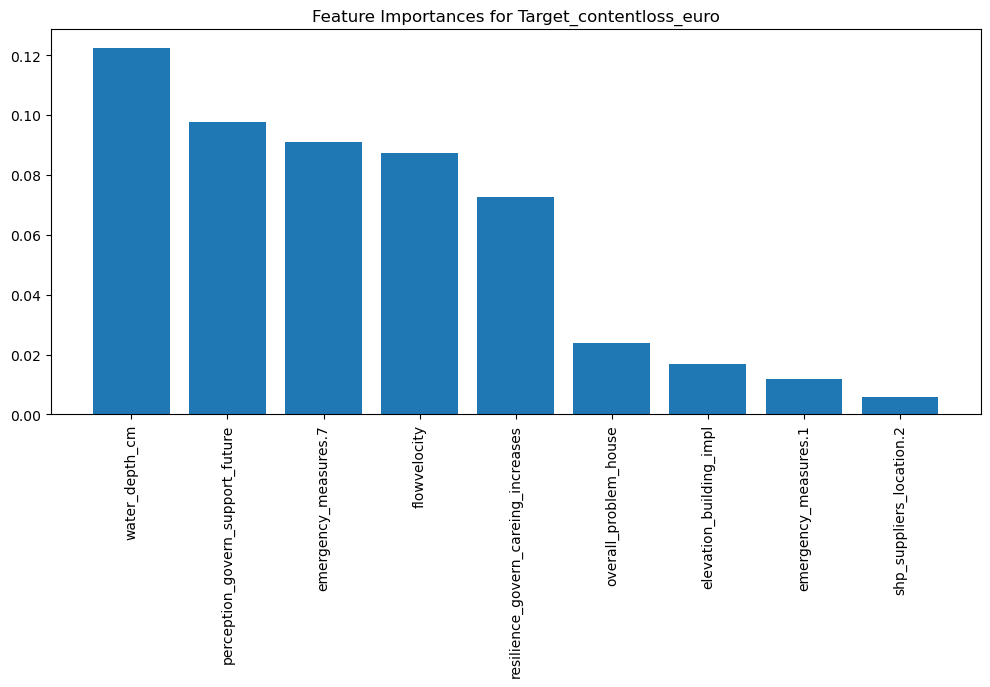

In [13]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

## coef of feature importances
importance = elastic_net_eval.estimator_.coef_[0]
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : elastic_net.coef_,
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0, : ] 
df_importance = df_importance.sort_values("importances", ascending=False)

plt.bar(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

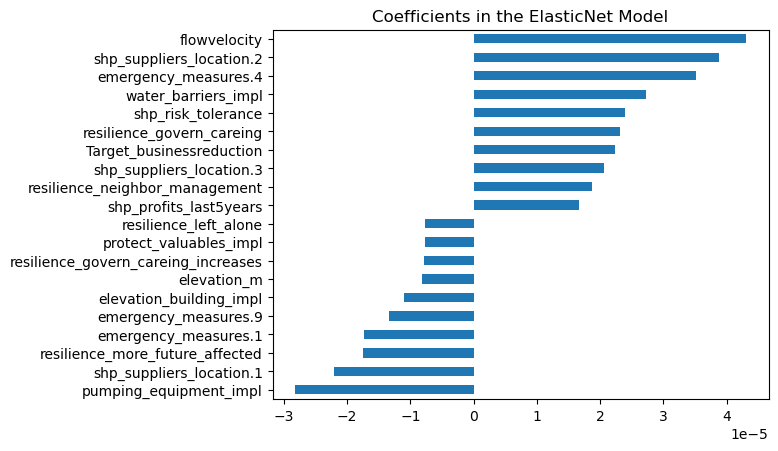

In [139]:

coef = pd.Series(elastic_net.coef_, index = X_train.columns)
important_features = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
important_features.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")